# Priority Classification Model
## Smart Civic Issue & Waste Management System

This notebook builds a priority classification model to assist municipal
authorities in identifying high-urgency civic complaints.

The model uses engineered spatial and categorical features to classify
complaints into LOW, MEDIUM, and HIGH priority levels.


### Model Selection Rationale

A Decision Tree classifier was selected as the primary model for priority
classification due to its interpretability and suitability for rule-based
decision systems. In civic governance applications, transparency of decision
logic is more important than marginal gains in predictive accuracy.

Decision Trees allow explicit inspection of decision paths, making it
possible to explain why a complaint is assigned a particular priority
level. This aligns well with administrative workflows where decisions
must be justified and audited.

To preserve interpretability and prevent overfitting, the tree depth
was intentionally constrained.

## 1. Importing Required Libraries

This section imports libraries required for model training, evaluation,
and result generation.

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

## 2. Loading Engineered Feature Dataset

The processed dataset generated from the feature engineering stage is loaded.
This dataset contains numerical features suitable for ML modeling.

In [7]:
# NOTE: Run from project-root (use `cd ..` if executing from notebooks/)
df = pd.read_csv("data/processed/features_data.csv")
df.head()

,ID,category_encoded,status_encoded,density_score,category_frequency,is_pending,risk_signal,Latitude,Longitude
0,1,0,2,0.295490,214,1,0.577294,23.257167,77.413640
1,2,3,1,0.170649,497,0,0.102390,23.258523,77.415287
2,3,1,1,0.246742,425,0,0.148045,23.256676,77.411646
3,4,3,1,0.099254,497,0,0.059552,23.261520,77.407977
4,5,2,2,0.176402,311,1,0.505841,23.257405,77.412233


## 3. Defining Priority Labels

Since labeled priority data is not available, priority classes are derived
using domain-informed rules based on complaint density, status, and risk signal.

This approach is known as rule-based bootstrapping and is acceptable for
decision-support systems.

In [9]:
def assign_priority(row):
    if row['risk_signal'] >= 0.7:
        return 2   # HIGH
    elif row['risk_signal'] >= 0.4:
        return 1   # MEDIUM
    else:
        return 0   # LOW

df['priority_label'] = df.apply(assign_priority, axis=1)
df[['risk_signal', 'priority_label']].head()

,risk_signal,priority_label
0,0.577294,1
1,0.102390,0
2,0.148045,0
3,0.059552,0
4,0.505841,1


0 → LOW priority
1 → MEDIUM priority
2 → HIGH priority

## 4. Priority Class Distribution

This section checks whether priority classes are reasonably balanced.

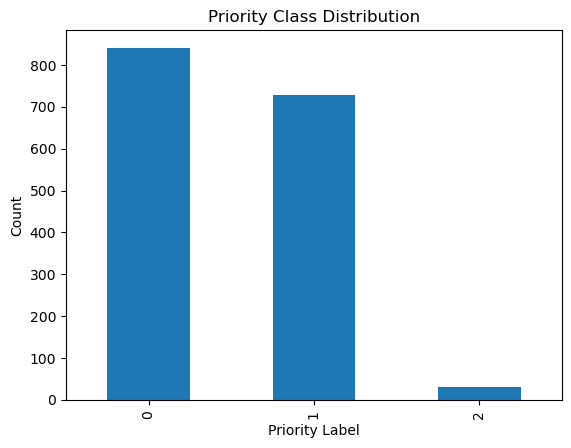

In [12]:
df['priority_label'].value_counts().plot(kind='bar')
plt.title("Priority Class Distribution")
plt.xlabel("Priority Label")
plt.ylabel("Count")
plt.show()

## 5. Feature Selection for Priority Model

The following features are selected based on EDA insights and domain relevance.

In [14]:
X = df[
    [
        'category_encoded',
        'status_encoded',
        'density_score',
        'category_frequency',
        'is_pending',
        'risk_signal'
    ]
]

y = df['priority_label']

In [15]:
feature_names = X.columns.tolist()
feature_names

['category_encoded',
 'status_encoded',
 'density_score',
 'category_frequency',
 'is_pending',
 'risk_signal']

The model uses engineered features that capture spatial density, complaint
frequency, and resolution status. Raw text and image data are intentionally
excluded at this stage to preserve interpretability and reduce model
complexity.

### Priority Label Distribution

Before training the classification model, the distribution of priority labels
is analyzed to understand class balance within the dataset.

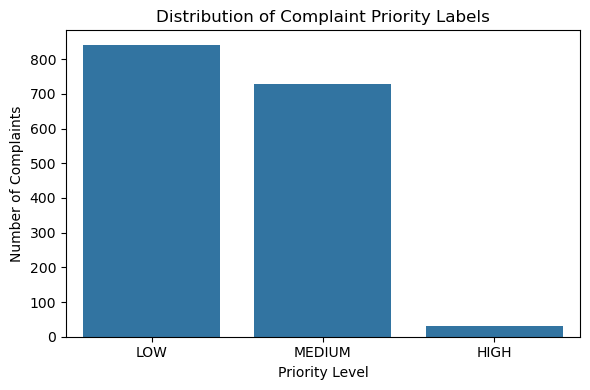

In [18]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['priority_label'], order=[0,1,2])
plt.xticks([0,1,2], ['LOW', 'MEDIUM', 'HIGH'])
plt.title("Distribution of Complaint Priority Labels")
plt.xlabel("Priority Level")
plt.ylabel("Number of Complaints")
plt.tight_layout()
plt.show()

## 6. Train–Test Split

The dataset is split into training and testing subsets to evaluate
model generalization.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 7. Training the Priority Classification Model

A Decision Tree classifier is used due to its interpretability and
suitability for governance-oriented decision systems.

In [22]:
model = DecisionTreeClassifier(
    max_depth=4,
    random_state=42
)

model.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",4
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current no

## 8. Model Evaluation

This section evaluates the trained model using accuracy and class-wise metrics.

In [24]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       169
           1       1.00      1.00      1.00       146
           2       1.00      1.00      1.00         5

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320



### Predicted Priority Distribution

The distribution of predicted priority labels on the test set is visualized
to analyze the model's classification behavior across different priority levels.

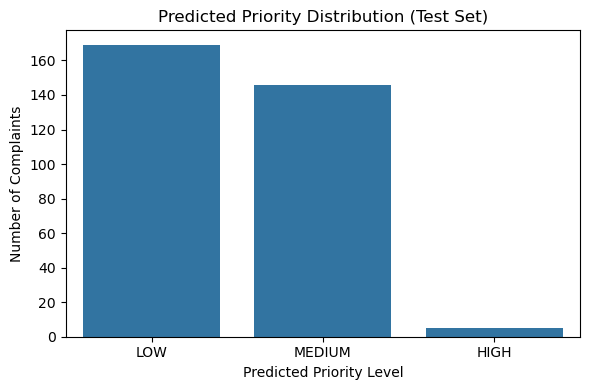

In [26]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_pred, order=[0,1,2])
plt.xticks([0,1,2], ['LOW', 'MEDIUM', 'HIGH'])
plt.title("Predicted Priority Distribution (Test Set)")
plt.xlabel("Predicted Priority Level")
plt.ylabel("Number of Complaints")
plt.tight_layout()
plt.show()

## 9. Risk Score Generation

Priority labels are converted into a human-readable risk score to support
dashboard visualization and decision-making.

In [28]:
priority_to_risk = {
    0: 3,   # LOW
    1: 6,   # MEDIUM
    2: 9    # HIGH
}

df['risk_score'] = df['priority_label'].map(priority_to_risk)
df[['priority_label', 'risk_score']].head()

,priority_label,risk_score
0,1,6
1,0,3
2,0,3
3,0,3
4,1,6


## 10. Human-Readable Priority Levels

Numeric labels are converted into descriptive priority levels.

In [30]:
priority_names = {
    0: "LOW",
    1: "MEDIUM",
    2: "HIGH"
}

df['priority_level'] = df['priority_label'].map(priority_names)
df[['priority_level', 'risk_score']].head()

,priority_level,risk_score
0,MEDIUM,6
1,LOW,3
2,LOW,3
3,LOW,3
4,MEDIUM,6


## 11. Saving Priority Model Results

The priority classification results are saved for dashboard integration
and reporting.

In [32]:
output_cols = [
    'ID',
    'priority_label',
    'priority_level',
    'risk_score'
]

df[output_cols].to_csv(
    "data/processed/priority_results.csv",
    index=False
)

print("priority_results.csv saved successfully.")

priority_results.csv saved successfully.


## 12. Summary of Priority Classification Model

### Model Highlights:
- Interpretable Decision Tree classifier
- Rule-bootstrapped priority labels
- Spatial density and status-aware risk scoring

### Practical Impact:
- Enables authorities to triage complaints effectively
- Reduces manual inspection overhead
- Supports transparent and ethical decision-making

The next stage applies spatial clustering for hotspot detection.